# process_data

In [12]:
import os
import json
import pandas as pd
from collections import defaultdict

# -------------------------------
# 配置路径
# -------------------------------
BASE_DIR = r"C:\Users\mhuiuyd\Desktop\RAW_TRACKS\National University of Singapore\Sandesh Sreepathy Upadhyaya - Football Dataset"
SEASON_FOLDERS = ["2425_FINAL", "2526_FINAL"]
OUTPUT_CSV = "player_summary_all_seasons.csv"

TARGET_JSONS = [
    "defense_all.json",
    "keeper_all.json",
    "misc_all.json",
    "passing_all.json",
    "passing_types_all.json",
    "possession_all.json",
    "summary_all.json"
]


# -------------------------------
# 工具函数
# -------------------------------
def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return None


def clean_info_fields(info):
    """clean info.json abnormal seg"""
    def is_invalid_height(val: str):
        if not val:
            return False
        val = val.strip()
        if any(keyword in val for keyword in [
            "January", "February", "March", "April", "May", "June", "July",
            "August", "September", "October", "November", "December",
            "Age", "-", "/", "born", "Born"
        ]):
            return True

        if len(val) > 10 and not any(ch.isdigit() for ch in val):
            return True
        return False

    def is_invalid_weight(val: str):
        if not val:
            return False
        val = val.strip()

        if "Age" in val or any(m in val for m in ["year", "born", "(", ")"]):
            return True
        if len(val) > 8 and not any(ch.isdigit() for ch in val):
            return True
        return False

    if "height" in info and is_invalid_height(info["height"]):
        info["height"] = ""
    if "weight" in info and is_invalid_weight(info["weight"]):
        info["weight"] = ""
    return info


# -------------------------------
# main logic
# -------------------------------
def process_player_folder_clean(player_folder):
    """处理单个球员文件夹，返回 { 'name':..., 'height':..., 平均值..., 'Pos_set':... }"""
    info_path = os.path.join(player_folder, "info.json")
    if not os.path.exists(info_path):
        return None

    try:
        with open(info_path, "r", encoding="utf-8") as f:
            info = json.load(f)
    except Exception:
        return None

    # 清洗异常 info
    info = clean_info_fields(info)

    player_name = info.get("name", None)
    if not player_name:
        return None

    numeric_max = {}  # 存储不同文件间的最大值
    match_num = 0
    pos_set = set()

    for file_name in TARGET_JSONS:
        file_path = os.path.join(player_folder, file_name)
        if not os.path.exists(file_path):
            continue

        candidate_match_num = 0
        file_sums = defaultdict(float)
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception:
            continue

        for item in data:
            min_val = safe_float(item.get("Min"))
            if min_val is None:
                continue
            candidate_match_num += 1

            for k, v in item.items():
                val = safe_float(v)
                if val is not None:
                    file_sums[k] += val

            pos_val = item.get("Pos", "")
            if pos_val and pos_val != "On matchday squad, but did not play":
                for p in pos_val.replace(" ", "").split(","):
                    if p:
                        pos_set.add(p)

        # 不同文件间取最大值
        for k, v in file_sums.items():
            if k in numeric_max:
                numeric_max[k] = max(numeric_max[k], v)
            else:
                numeric_max[k] = v

        match_num = max(match_num, candidate_match_num)

    numeric_max["Pos_set"] = ", ".join(sorted(pos_set))
    numeric_max["Match_num"] = match_num

    return {**info, **numeric_max}


def aggregate_all_players_clean():
    all_players = defaultdict(lambda: defaultdict(list))
    all_positions = defaultdict(set)
    base_info = {}

    for season in SEASON_FOLDERS:
        season_path = os.path.join(BASE_DIR, season)
        if not os.path.exists(season_path):
            print(f"⚠️ skip not exist folder: {season_path}")
            continue

        for club in os.listdir(season_path):
            club_path = os.path.join(season_path, club)
            if not os.path.isdir(club_path):
                continue

            for player in os.listdir(club_path):
                player_folder = os.path.join(club_path, player)
                if not os.path.isdir(player_folder):
                    continue

                result = process_player_folder_clean(player_folder)
                if not result:
                    continue

                name = result.get("name")
                base_info[name] = {k: result[k] for k in ["name", "height", "weight", "Footed"] if k in result}

                for k, v in result.items():
                    if isinstance(v, (int, float)):
                        all_players[name][k].append(v)
                if "Pos_set" in result and result["Pos_set"]:
                    all_positions[name].update(result["Pos_set"].split(", "))

    summary_rows = []
    for name in all_players:
        info = base_info.get(name, {})
        avg_dict = {k: sum(vs) for k, vs in all_players[name].items()}
        avg_dict["Pos_set"] = ", ".join(sorted(all_positions[name]))
        summary_rows.append({**info, **avg_dict})

    df = pd.DataFrame(summary_rows)
    df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
    print(f"✅ aggregate across season: {OUTPUT_CSV}")
    print(f"📊 in totall {len(df)} players")


if __name__ == "__main__":
    aggregate_all_players_clean()


✅ aggregate across season: player_summary_all_seasons.csv
📊 in totall 855 players


In [13]:
import os
import json
import pandas as pd
from collections import defaultdict

# -------------------------------
# 配置路径
# -------------------------------
CSV_FILE = "player_summary_all_seasons.csv"

def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return None

def process_player_summary(player_folder):
    """
    只读取 summary_all.json，统计每个位置出场分钟，计算熟练比重
    """
    summary_path = os.path.join(player_folder, "summary_all.json")
    if not os.path.exists(summary_path):
        return None

    with open(summary_path, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
        except Exception:
            return None

    pos_minutes = defaultdict(float)
    match_num = 0
    player_name = None

    for item in data:
        min_val = safe_float(item.get("Min"))
        if min_val is None:
            continue
        match_num += 1

        if not player_name:
            player_name = item.get("Player", None) or item.get("name", None)

        pos_val = item.get("Pos", "")
        if pos_val and pos_val != "On matchday squad, but did not play":
            positions = [p for p in pos_val.replace(" ", "").split(",") if p]
            for p in positions:
                pos_minutes[p] += min_val

    total_min = sum(pos_minutes.values())
    pos_weights = {p: pos_minutes[p] / total_min if total_min > 0 else 0 for p in pos_minutes}

    return player_name, pos_weights

# -------------------------------
# 读取原 CSV
# -------------------------------
df = pd.read_csv(CSV_FILE)

# -------------------------------
# 处理每个球员
# -------------------------------
pos_weights_list = []
for player_name in df['name']:
    found = False
    for season in SEASON_FOLDERS:
        season_path = os.path.join(BASE_DIR, season)
        for club in os.listdir(season_path):
            club_path = os.path.join(season_path, club)
            player_folder = os.path.join(club_path, player_name)
            if os.path.isdir(player_folder):
                result = process_player_summary(player_folder)
                if result:
                    _, pos_weights = result
                    pos_weights_list.append(pos_weights)
                    found = True
                    break
        if found:
            break
    if not found:
        pos_weights_list.append({})  # 未找到的球员留空字典

# -------------------------------
# 添加 Pos_weights 列并保存
# -------------------------------
df['Pos_weights'] = pos_weights_list
df.to_csv(CSV_FILE, index=False, encoding="utf-8-sig")
print(f"✅ add {CSV_FILE}  Pos_weights col")


✅ add player_summary_all_seasons.csv  Pos_weights col


In [14]:
def parse_weights(weights_str):
        try:
            return eval(weights_str) if pd.notna(weights_str) else {}
        except:
            return {}

def split_WB_posset(weights, posset):
    """
    将 WB 拆分成 LWB/RWB，更新 weights 和 posset
    weights: dict, 位置 -> 权重（含 WB）
    posset: list, 位置集合（含 WB）
    返回: (new_weights, new_posset)
    """
    w_WB = weights.get('WB', 0)
    if w_WB == 0:
        return weights, posset  # 没有 WB，直接返回

    # 定义左右位置集合
    left_positions = ['LB','LM','LW']
    right_positions = ['RB','RM','RW']

    total_L = sum(weights.get(p,0) for p in left_positions)
    total_R = sum(weights.get(p,0) for p in right_positions)
    total = total_L + total_R

    if total == 0:
        ratio_L, ratio_R = 0.5, 0.5
    else:
        ratio_L = total_L / total
        ratio_R = total_R / total

    # 拆分 WB 权重
    w_LWB = w_WB * ratio_L
    w_RWB = w_WB * ratio_R

    # 更新 weights
    new_weights = weights.copy()
    new_weights.pop('WB')
    if w_LWB > 0:
        new_weights['LWB'] = w_LWB
    if w_RWB > 0:
        new_weights['RWB'] = w_RWB

    # 更新 posset
    new_posset = [p for p in posset if p != 'WB']
    if w_LWB > 0:
        new_posset.append('LWB')
    if w_RWB > 0:
        new_posset.append('RWB')

    return new_weights, new_posset

In [15]:
import pandas as pd
import numpy as np

# 读取 CSV 文件
df = pd.read_csv("player_summary_all_seasons.csv")

# 保留原样的字段
keep_cols = ["name", "height", "weight", "Footed", "Pos_set", "Match_num", "Min",'Pos_weights']

# 找到带%和非带%的数值列
percent_cols = [c for c in df.columns if "%" in c and c not in keep_cols]
numeric_cols = [c for c in df.columns if c not in keep_cols + percent_cols]

# 避免除0，先替换 Min 和 Match_num 为 1 的临时值
df["Min_temp"] = df["Min"].replace(0, 1)
df["Match_num_temp"] = df["Match_num"].replace(0, 1)

# 带%列除以 Match_num
for col in percent_cols:
    df[col] = df[col] / df["Match_num_temp"]

# 其他数值列除以 Min
for col in numeric_cols:
    df[col] = df[col] / df["Min_temp"]

# 删除临时列
df = df.drop(columns=["Min_temp", "Match_num_temp"])

df['Pos_set'] = df['Pos_weights'].apply(
    lambda w: split_WB_posset(
        parse_weights(w),
        list(parse_weights(w).keys()) if isinstance(parse_weights(w), dict) else list(range(len(parse_weights(w))))
    )[1]
)

df['Pos_weights'] = df['Pos_weights'].apply(
    lambda w: split_WB_posset(
        parse_weights(w),
        list(parse_weights(w).keys()) if isinstance(parse_weights(w), dict) else list(range(len(parse_weights(w))))
    )[0]
)
# 保存
df.to_csv("player_features.csv", index=False, encoding="utf-8-sig")

negative_cols = [
    "Err",
    "Lost",
    "GA",
    "Mis"
    ]
for col in negative_cols:
    if col in df.columns:
        df[f"{col}_inv"] = -df[col]  # 取相反数
        # 如果希望删除原列，可以加上： df.drop(columns=[col], inplace=True)

# 保存修改后的 CSV
df.to_csv("player_features_inverted.csv", index=False, encoding="utf-8-sig")
print("✅ generate modified file：player_features_inverted.csv")



✅ generate modified file：player_features_inverted.csv


# pos_encode

**build_map**

In [16]:
import pandas as pd

# 读取 CSV 文件
df = pd.read_csv("player_features.csv", encoding="utf-8-sig")  # 根据文件实际编码调整

# 用于存放所有出现过的职位
all_positions = set()

# 遍历 Pos_set 列
for pos_str in df["Pos_set"].fillna(""):
    positions = [p.strip() for p in pos_str.split(",") if p.strip()]
    all_positions.update(positions)

# 打印结果
print("all presented Pos_set element：")
print(sorted(all_positions))


all presented Pos_set element：
["'AM'", "'AM']", "'CB'", "'CB']", "'CM'", "'CM']", "'DM'", "'DM']", "'FW'", "'FW']", "'LB'", "'LB']", "'LM'", "'LM']", "'LW'", "'LW']", "'LWB'", "'LWB']", "'RB'", "'RB']", "'RM'", "'RM']", "'RW'", "'RW']", "'RWB']", "['AM'", "['AM']", "['CB'", "['CB']", "['CM'", "['CM']", "['DM'", "['FW'", "['FW']", "['GK']", "['LB'", "['LB']", "['LM'", "['LW'", "['RB'", "['RB']", "['RM'", "['RW'", "['RW']", '[]']


In [17]:
distances = {
    ('FW','AM'): 4,
    ('FW','LW'): 2,
    ('FW','RW'): 2,
    ('FW','LM'): 5,
    ('FW','RM'): 5,
    ('FW','LWB'): 7,
    ('FW','RWB'): 7,
    ('FW','LB'): 8,
    ('FW','RB'): 8,
    ('FW','CM'): 7,
    ('FW','DM'): 8,
    ('FW','CB'): 9,

    ('AM','LW'): 2,
    ('AM','RW'): 2,
    ('AM','LM'): 2,
    ('AM','RM'): 2,
    ('AM','LWB'): 5,
    ('AM','RWB'): 5,
    ('AM','LB'): 6,
    ('AM','RB'): 6,
    ('AM','CM'): 1,
    ('AM','DM'): 4,
    ('AM','CB'): 7,

    ('CM','LW'): 4,
    ('CM','RW'): 4,
    ('CM','LM'): 2,
    ('CM','RM'): 2,
    ('CM','LWB'): 4,
    ('CM','RWB'): 4,
    ('CM','LB'): 4,
    ('CM','RB'): 4,
    ('CM','DM'): 1,
    ('CM','CB'): 6,

    ('DM','LW'): 6,
    ('DM','RW'): 6,
    ('DM','LM'): 4,
    ('DM','RM'): 4,
    ('DM','LWB'): 2,
    ('DM','RWB'): 2,
    ('DM','LB'): 3,
    ('DM','RB'): 3,
    ('DM','CB'): 2,

    ('CB','LW'): 7,
    ('CB','RW'): 7,
    ('CB','LM'): 6,
    ('CB','RM'): 6,
    ('CB','LWB'): 4,
    ('CB','RWB'): 4,
    ('CB','LB'): 2,
    ('CB','RB'): 2,

    ('LB','LW'): 5,
    ('LB','RW'): 9,
    ('LB','LM'): 2,
    ('LB','RM'): 6,
    ('LB','LWB'): 1,
    ('LB','RWB'): 5,
    ('LB','RB'): 4,

    ('RB','LW'): 9,
    ('RB','RW'): 5,
    ('RB','LM'): 6,
    ('RB','RM'): 2,
    ('RB','LWB'): 5,
    ('RB','RWB'): 1,

    ('RWB','LW'): 8,
    ('RWB','RW'): 4,
    ('RWB','LM'): 5,
    ('RWB','RM'): 1,
    ('RWB','LWB'): 4,

    ('LWB','LW'): 4,
    ('LWB','RW'): 8,
    ('LWB','LM'): 1,
    ('LWB','RM'): 5,

    ('LM','LW'): 1,
    ('LM','RW'): 7,
    ('LM','RM'): 4,

    ('RM','LW'): 7,
    ('RM','RW'): 1,

    ('RW','LW'): 4
}

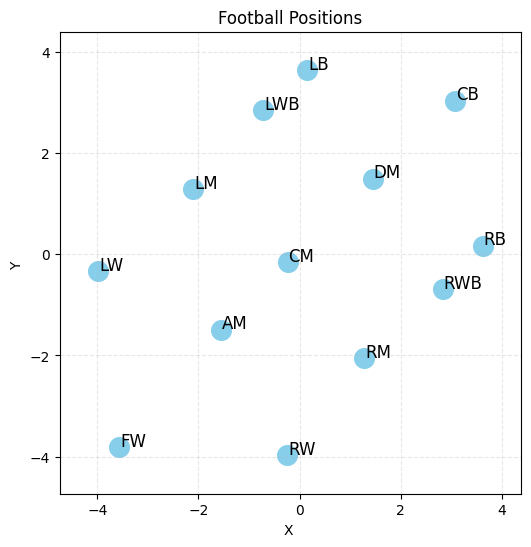

In [18]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

def positions_to_coords(dist_dict=distances, n_dim=2, random_state=42):
    """
    将位置间距离规则映射成坐标。
    
    参数：
    - dist_dict: dict, 形如 {('ST','CF'):0.1, ('ST','CB'):1.0, ...}，表示已知距离
    - n_dim: int, 坐标维度
    - random_state: int, 随机种子
    
    返回：
    - pos_coords: dict, 位置->坐标 ndarray
    """
    # 1. 获取所有位置
    positions = sorted({p for pair in dist_dict.keys() for p in pair})
    n_pos = len(positions)
    pos_index = {p:i for i,p in enumerate(positions)}
    
    # 2. 构建完整距离矩阵（未知距离用较大值或平均值）
    dist_matrix = np.zeros((n_pos,n_pos))
    for i in range(n_pos):
        for j in range(n_pos):
            if i == j:
                dist_matrix[i,j] = 0
            else:
                key1 = (positions[i], positions[j])
                key2 = (positions[j], positions[i])
                if key1 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key1]
                elif key2 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key2]
                else:
                    dist_matrix[i,j] = 1.0  # 默认距离，可根据需要调整

    # 3. MDS映射
    mds = MDS(n_components=n_dim, dissimilarity='precomputed', random_state=random_state)
    coords = mds.fit_transform(dist_matrix)
    
    # 4. 输出字典
    pos_coords = {p: coords[pos_index[p]] for p in positions}
    return pos_coords

coords = positions_to_coords()
# 提取所有 x, y
xs = [x for x, y in coords.values()]
ys = [y for x, y in coords.values()]

# 创建图
plt.figure(figsize=(8,6))
plt.title("Football Positions")
plt.xlabel("X ")
plt.ylabel("Y ")

# 画每个位置
for pos, (x, y) in coords.items():
    plt.scatter(x, y, s=200, c='skyblue')
    plt.text(x+0.02, y+0.02, pos, fontsize=12)

# 自动设置坐标范围并加边距
x_margin = (max(xs)-min(xs))*0.1
y_margin = (max(ys)-min(ys))*0.1
plt.xlim(min(xs)-x_margin, max(xs)+x_margin)
plt.ylim(min(ys)-y_margin, max(ys)+y_margin)

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()


In [19]:
import math

# 对称化距离字典
sym_distances = {}
for (a,b), d in distances.items():
    sym_distances[(a,b)] = d
    sym_distances[(b,a)] = d
    sym_distances[(a,a)] = 0
    sym_distances[(b,b)] = 0

def weighted_posset_distance(setA, setB, weightsA, weightsB, default_distance=10):
    """
    计算两个球员位置集合的加权距离
    setA, setB: list of position
    weightsA, weightsB: dict，位置 -> 熟练比重
    """
    if not setA or not setB:
        return float('inf')
    
    total_dist = 0
    for a in setA:
        for b in setB:
            dist = sym_distances.get((a,b), default_distance)
            total_dist += dist * weightsA.get(a,0) * weightsB.get(b,0)
    return total_dist

def weighted_posset_similarity(setA, setB, weightsA, weightsB, alpha=0.5):
    d = weighted_posset_distance(setA, setB, weightsA, weightsB)
    return math.exp(-alpha*d)

# ------------------------------
# 示例
# ------------------------------
player1 = ['CB']
weights1 = {'CB':1}   # 熟练比重

player2 = ['CB','LB','RB']
weights2 = {'CB': 0.9719495091164095, 'LB': 0.02208976157082749, 'RB': 0.005960729312762973}

dist = weighted_posset_distance(player1, player2, weights1, weights2)
sim = weighted_posset_similarity(player1, player2, weights1, weights2)

print("weighted set dist:", dist)
print("weighted set sim:", sim)


weighted set dist: 0.056100981767180924
weighted set sim: 0.9723392712928622


In [20]:
import math

# coords 是位置到坐标的映射
# 示例：
# coords = {
#     "CB": (0.75, -0.68),
#     "LB": (-0.48, 0.13),
#     ...
# }



def player_weighted_coord(posset, weights, coords=coords):
    """
    计算球员加权坐标
    posset: list of 位置字符串
    weights: dict, 位置 -> 权重
    coords: dict, 位置 -> (x,y) 坐标
    """
    weights, posset = split_WB_posset(weights,posset)
    total_weight = sum(weights.get(p, 0) for p in posset)
    if total_weight == 0:
        return (0,0)
    
    x = sum(coords[p][0] * weights.get(p, 0) for p in posset) / total_weight
    y = sum(coords[p][1] * weights.get(p, 0) for p in posset) / total_weight
    return (x, y)

def weighted_coord_similarity(possetA, weightsA, possetB, weightsB, coords=coords, alpha=1.0):
    """
    基于加权坐标的欧氏距离计算相似度
    """
    x1, y1 = player_weighted_coord(possetA, weightsA, coords)
    x2, y2 = player_weighted_coord(possetB, weightsB, coords)
    dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
    return math.exp(-alpha*dist)

# ------------------------------
# 示例
# ------------------------------
player1_pos = ['CB']
player1_weights = {'CB': 1}

player2_pos = ['CB','LB','RB']
player2_weights = {'CB': 0.97, 'LB': 0.02, 'RB': 0.01}

sim = weighted_coord_similarity(player1_pos, player1_weights,
                                player2_pos, player2_weights,
                                coords, alpha=1.5)

print("weighted coord sim:", sim)


weighted coord sim: 0.9203365512608005


In [21]:
import pandas as pd
import itertools
import math

# -----------------------------
# 假设 sym_distances 已定义
# posset_distance_weighted 和 posset_similarity_weighted 已定义
# -----------------------------

# 读取 CSV
df = pd.read_csv("player_features.csv")
df['Pos_set'] = df['Pos_set'].astype(str)

# 示例球员列表
player_names = ["Bukayo Saka", "Jakub Kiwior", "Nicolas Jackson", 
                "Amadou Onana", "Ryan Gravenberch", "Mohamed Salah", "Virgil van Dijk"]

# 构建球员到 Pos_set 和 Pos_weights 的映射
player_possets = {}
player_posweights = {}
for _, row in df.iterrows():
    name = row['name']
    if name not in player_names:
        continue
    # Pos_set
    pos_list = row['Pos_set'].split(', ') if pd.notna(row['Pos_set']) else []
    player_possets[name] = pos_list
    # Pos_weights
    try:
        weights = eval(row['Pos_weights']) if pd.notna(row['Pos_weights']) else {}
    except:
        weights = {}
    player_posweights[name] = weights

# 保存相似度结果
similarities = []
similarities1 = []
# 两两组合计算加权相似度
for p1, p2 in itertools.combinations(player_names, 2):
    if p1 in player_possets and p2 in player_possets:
        set1 = player_possets[p1]
        set2 = player_possets[p2]
        weights1 = player_posweights.get(p1, None)
        if len(weights1) == 0:
            print(p1+" has no pos weight") 
            similarities.append((p1, p2, 0))
            continue
        weights2 = player_posweights.get(p2, None)
        if len(weights2) == 0:
            print(p2+" has no pos weight") 
            similarities.append((p1, p2, 0))
            continue

        sim1 = weighted_posset_similarity(set1, set2, weights1, weights2)
        sim = weighted_coord_similarity(set1, weights1,
                                set2, weights2)
        similarities.append((p1, p2, sim))
        similarities1.append((p1, p2, sim1))

# 按相似度从高到低排序
similarities_sorted = sorted(similarities, key=lambda x: x[2], reverse=True)
similarities_sorted1 = sorted(similarities1, key=lambda x: x[2], reverse=True)

# 输出结果
print("coord sim")
for p1, p2, sim in similarities_sorted:
    print(f"{p1} - {p2}: {sim:.4f}")
print("\nset sim")
for p1, p2, sim in similarities_sorted1:
    print(f"{p1} - {p2}: {sim:.4f}")


coord sim
Bukayo Saka - Jakub Kiwior: 1.0000
Bukayo Saka - Nicolas Jackson: 1.0000
Bukayo Saka - Amadou Onana: 1.0000
Bukayo Saka - Ryan Gravenberch: 1.0000
Bukayo Saka - Mohamed Salah: 1.0000
Bukayo Saka - Virgil van Dijk: 1.0000
Jakub Kiwior - Nicolas Jackson: 1.0000
Jakub Kiwior - Amadou Onana: 1.0000
Jakub Kiwior - Ryan Gravenberch: 1.0000
Jakub Kiwior - Mohamed Salah: 1.0000
Jakub Kiwior - Virgil van Dijk: 1.0000
Nicolas Jackson - Amadou Onana: 1.0000
Nicolas Jackson - Ryan Gravenberch: 1.0000
Nicolas Jackson - Mohamed Salah: 1.0000
Nicolas Jackson - Virgil van Dijk: 1.0000
Amadou Onana - Ryan Gravenberch: 1.0000
Amadou Onana - Mohamed Salah: 1.0000
Amadou Onana - Virgil van Dijk: 1.0000
Ryan Gravenberch - Mohamed Salah: 1.0000
Ryan Gravenberch - Virgil van Dijk: 1.0000
Mohamed Salah - Virgil van Dijk: 1.0000

set sim
Bukayo Saka - Jakub Kiwior: 1.0000
Bukayo Saka - Nicolas Jackson: 1.0000
Bukayo Saka - Amadou Onana: 1.0000
Bukayo Saka - Ryan Gravenberch: 1.0000
Bukayo Saka - Moha

# CLUSTER EVAL


In [22]:
rule_anti_groups = [
    ["Virgil van Dijk", "Ibrahima Konaté"],
    ["Trent Alexander-Arnold", "Conor Bradley"],
    ["Conor Bradley", "Reece James"],
    ["Alexander Isak", "Erling Haaland"],
    ["Ryan Gravenberch","Moisés Caicedo","Enzo Fernández"],
    ["James Maddison","Dominik Szoboszlai"],
    ["Nicolas Jackson","Erling Haaland"],
    ["Jeremie Frimpong","Trent Alexander-Arnold"],
    ["Trent Alexander-Arnold", "Conor Bradley"],
    ["Jeremie Frimpong", "Conor Bradley"],
    ["Mohamed Salah","Phil Foden"],
    ["Jack Grealish","Luis Díaz"],
    ["Brennan Johnson","Mohamed Salah"],
    ["Marc Guéhi", "Ibrahima Konaté"],
    ["Roméo Lavia","Moisés Caicedo"]
]

rule_groups = [
    ["Alexander Isak","Hugo Ekitike"],
    ["Alejandro Garnacho","Gabriel Martinelli"],
    ["Harry Maguire","Virgil van Dijk"],
    ["Bryan Mbeumo","Mohamed Salah"],
    ["Erling Haaland","Benjamin Šeško"]
]
def evaluate_rules(df, labels, rule_groups=rule_groups, rule_anti_groups=rule_anti_groups):
    df_temp = df.copy()
    df_temp['cluster'] = labels
    satisfied = 0
    for group in rule_anti_groups:
        # 获取每个球员所在簇
        clusters = df_temp[df_temp['name'].isin(group)]['cluster'].values
        # 如果所有簇都不重复 → 规则满足
        if len(clusters) == len(set(clusters)):
            satisfied += 1/len(rule_anti_groups)
    for group in rule_groups:
        # 获取每个球员所在簇
        clusters = df_temp[df_temp['name'].isin(group)]['cluster'].values
        # 如果所有簇都重复 → 规则满足
        if len(set(clusters)) == 1:
            satisfied += 1/len(rule_groups)
    return satisfied/2   # 返回比例

In [23]:
def violated_rules_with_clusters(df, labels, rule_groups=rule_groups, rule_anti_groups=rule_anti_groups):
    """返回违反规则的球员名字及其簇"""
    df_temp = df.copy()
    df_temp['cluster'] = labels
    violated_info = []
    
    for i, group in enumerate(rule_anti_groups):
        # 获取组内球员簇
        clusters = df_temp[df_temp['name'].isin(group)][['name','cluster']]
        # 如果簇重复 → 规则被违反
        if len(clusters['cluster'].unique()) < len(clusters):
            violated_info.append((i, clusters))
        
    for i, group in enumerate(rule_groups):
        # 获取组内球员簇
        clusters = df_temp[df_temp['name'].isin(group)][['name','cluster']]
        # 如果簇重复 → 规则被违反
        if len(clusters['cluster'].unique()) > 1:
            violated_info.append((i, clusters))
    
    return violated_info

# PREPROCESS

In [24]:
# ------------------------------
# 读取数据
# ------------------------------
df = pd.read_csv("player_features_inverted.csv")
df = df.dropna(subset=['height', 'weight', 'Footed']).copy()
df.to_csv("player_features_inverted.csv", index=False, encoding='utf-8-sig')
# ------------------------------
# 列名分组
# ------------------------------

# 基础身体属性
identity_cols = ["name"]

physical_cols = [
    'height','weight','Footed'
]

# 防守指标
defense_cols = [
    'Tkl','TklW','Blocks','Int','Clr','Err_inv','Tkl%','Tkl+Int','Def 3rd','Mid 3rd','Att 3rd'
]

# 进攻 / 传球指标
offense_cols = [
    'Sh','Pass','Att','Lost_inv'
]

# 门将类指标（如果有）
gk_cols = [
    'SoTA','GA_inv'
]

# 触球 / 控球指标（之前的也可以补进来）
possession_cols = [
    'Touches','Carries','PrgC','CPA','Mis_inv','Dis','Rec','PrgR'
]

# 成功率
success_cols = ['Succ%','Tkld%']

other_cols = ['Pos_set','Pos_weights']

# 汇总
all_feature_cols = (
    identity_cols + physical_cols + defense_cols + offense_cols + 
    gk_cols + possession_cols + success_cols+other_cols
)

# 打印结果（便于直接复制）
print("cluster features:")
print(','.join(f"'{c}'" for c in all_feature_cols))
df = df[all_feature_cols].copy()


cluster features:
'name','height','weight','Footed','Tkl','TklW','Blocks','Int','Clr','Err_inv','Tkl%','Tkl+Int','Def 3rd','Mid 3rd','Att 3rd','Sh','Pass','Att','Lost_inv','SoTA','GA_inv','Touches','Carries','PrgC','CPA','Mis_inv','Dis','Rec','PrgR','Succ%','Tkld%','Pos_set','Pos_weights'


In [25]:

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
def df2X(df,output_csv = "player_features_processed.csv"):
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    posset_col = 'Pos_set'
    # 预处理NaN
    df[posset_col] = df[posset_col].astype(str)

    # ------------------------------
    # 忽略含GK的行
    # ------------------------------
    df_filtered = df[~df['Pos_set'].str.contains('GK')].copy()
    df_filtered = df_filtered[~df_filtered['Pos_weights'].str.contains('GK')].copy()
    df_filtered = df_filtered[~df_filtered['Pos_set'].str.contains('0')].copy()
    footed_onehot = pd.get_dummies(df_filtered['Footed'], prefix='Footed')
    df_filtered = pd.concat([df_filtered, footed_onehot], axis=1)

    weighted_coords = np.array([
        player_weighted_coord(
            list(parse_weights(row['Pos_weights']).keys()),  # 用 weights 的 keys 作为 posset
            parse_weights(row['Pos_weights'])                # 权重字典
        )
        for _, row in df_filtered.iterrows()
    ])


    # 数值列标准化
    # 自动筛选数值列
    numeric_cols = df_filtered.select_dtypes(include=np.number).columns.tolist()

    # 提取数值矩阵
    X_num = df_filtered[numeric_cols].values
    X_num = np.hstack([X_num, weighted_coords])

    # ① 先用 KNNImputer 填补空值
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    X_num_imputed = imputer.fit_transform(X_num)
    mean_arr = np.mean(X_num_imputed, axis=0)
    var_arr = np.var(X_num_imputed, axis=0)

    # ② 再标准化
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num_imputed)

    # ⑦ 输出 CSV
    df_temp = df_filtered[numeric_cols].copy()
    df_temp['name'] = df_filtered['name']
    df_temp['pos_x'] = weighted_coords[:, 0]
    df_temp['pos_y'] = weighted_coords[:, 1]
    df_temp.to_csv(output_csv, index=False, encoding='utf-8-sig')
    print(f"✅ new file stored to: {output_csv}, shape:{df_temp.shape}")

    return X_num_scaled,df_filtered,weighted_coords,mean_arr,var_arr
X, df_filtered, weighted_coords, mean_arr, var_arr=df2X(df)

print(X.shape)

✅ new file stored to: player_features_processed.csv, shape:(513, 31)
(513, 29)


# KMeans cosine SIM

In [78]:
import faiss

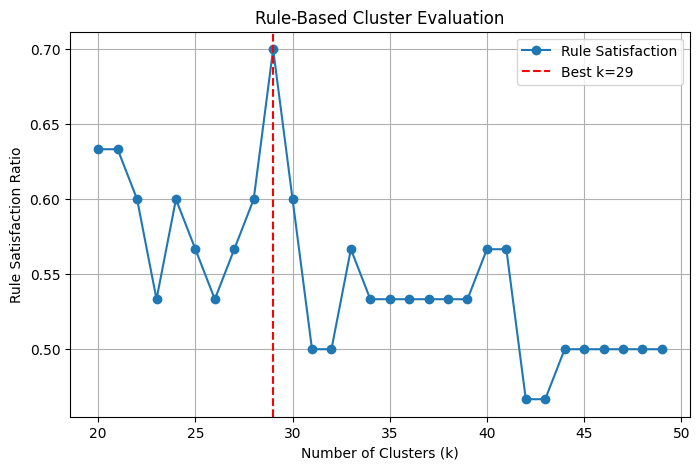

✅ 最优簇数: 29, 规则满足比例: 0.7000


In [ ]:

# 循环不同簇数
cluster_range = range(20, 50)
rule_scores = []

best_score = -1
best_k = None
best_labels = None
X = np.ascontiguousarray(X, dtype=np.float32)  # 保证连续且 float32
faiss.normalize_L2(X)
d = X.shape[1]
for k in cluster_range:
    kmeans = faiss.Kmeans(d, k, niter=50, spherical=True)
    kmeans.train(X)
    # ✅ 获取每个样本所属的簇
    index = faiss.IndexFlatIP(d)   # 使用内积（cosine）索引
    faiss.normalize_L2(kmeans.centroids)  # 再单位化一次，保证模=1
    index.add(kmeans.centroids)
    _, labels = index.search(X, 1)
    labels = labels.flatten()
    
    score = evaluate_rules(df_filtered, labels)
    rule_scores.append(score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels

# 绘制规则满足比例随簇数变化图
plt.figure(figsize=(8,5))
plt.plot(list(cluster_range), rule_scores, marker='o', label='Rule Satisfaction')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Rule Satisfaction Ratio")
plt.title("Rule-Based Cluster Evaluation")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ best k: {best_k}, rule satisfied rate: {best_score:.4f}")

In [ ]:


# 假设 best_labels 已经通过 KMeans 得到
violations = violated_rules_with_clusters(df_filtered, best_labels)

if len(violations) == 0:
    print("✅ 所有规则在最优簇数下都满足！")
else:
    print(f"⚠️ best k {best_k} still {len(violations)} remains not satisfied:\n")
    for idx, cluster_info in violations:
        print(f"rule {idx}:")
        print(cluster_info.to_string(index=False))
        print("-" * 40)


⚠️ 最优簇数 29 下仍有 3 条规则未满足：

规则 1:
              name  cluster
Gabriel Martinelli       15
Alejandro Garnacho       22
----------------------------------------
规则 2:
           name  cluster
Virgil van Dijk        9
  Harry Maguire       10
----------------------------------------
规则 4:
          name  cluster
Erling Haaland        1
Benjamin Šeško       26
----------------------------------------


In [81]:
# 聚类
kmeans = faiss.Kmeans(d, best_k, niter=50, spherical=True)
labels = kmeans.fit_predict(X)
centroids = kmeans.kmeans.centroids

AttributeError: 'Kmeans' object has no attribute 'fit_predict'

# KMeans Euclidean

In [26]:
from sklearn.cluster import KMeans

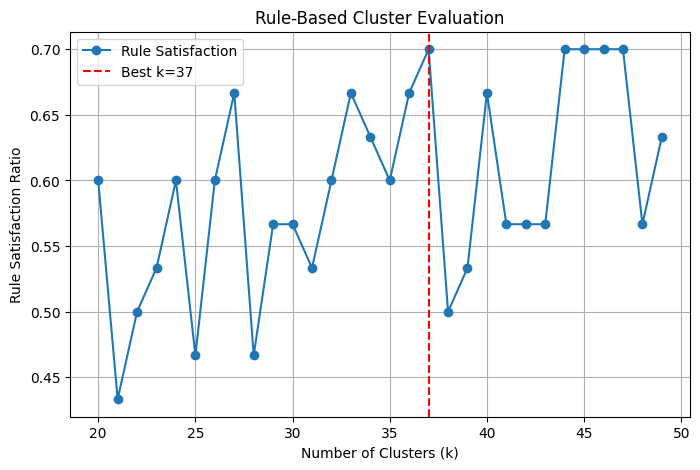

✅ best k: 37, rules satisfied : 0.7000


In [27]:

# 循环不同簇数
cluster_range = range(20, 50)
rule_scores = []

best_score = -1
best_k = None
best_labels = None

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    score = evaluate_rules(df_filtered, labels)
    rule_scores.append(score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels

# 绘制规则满足比例随簇数变化图
plt.figure(figsize=(8,5))
plt.plot(list(cluster_range), rule_scores, marker='o', label='Rule Satisfaction')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Rule Satisfaction Ratio")
plt.title("Rule-Based Cluster Evaluation")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ best k: {best_k}, rules satisfied : {best_score:.4f}")

In [28]:


# 假设 best_labels 已经通过 KMeans 得到
violations = violated_rules_with_clusters(df_filtered, best_labels)

if len(violations) == 0:
    print("✅ all rules satisfied on best k! ")
else:
    print(f"⚠️ best k {best_k} still have {len(violations)} rules not satisfied\n")
    for idx, cluster_info in violations:
        print(f"规则 {idx}:")
        print(cluster_info.to_string(index=False))
        print("-" * 40)


⚠️ best k 37 still have 3 rules not satisfied

规则 2:
           name  cluster
Virgil van Dijk       16
  Harry Maguire        8
----------------------------------------
规则 3:
         name  cluster
 Bryan Mbeumo       26
Mohamed Salah       33
----------------------------------------
规则 4:
          name  cluster
Erling Haaland       28
Benjamin Šeško        5
----------------------------------------


In [29]:
centroids = kmeans.cluster_centers_
# 聚类
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# AFTER CLUSTER

In [30]:


df_filtered['cluster'] = labels

# 按 cluster 排序
df_filtered_sorted = df_filtered.sort_values(by='cluster').reset_index(drop=True)

# 保存文件
df_filtered_sorted.to_csv("player_features_clustered_noGK_sorted.csv", encoding="utf-8-sig", index=False)

⚠️ Adam Wharton skipped


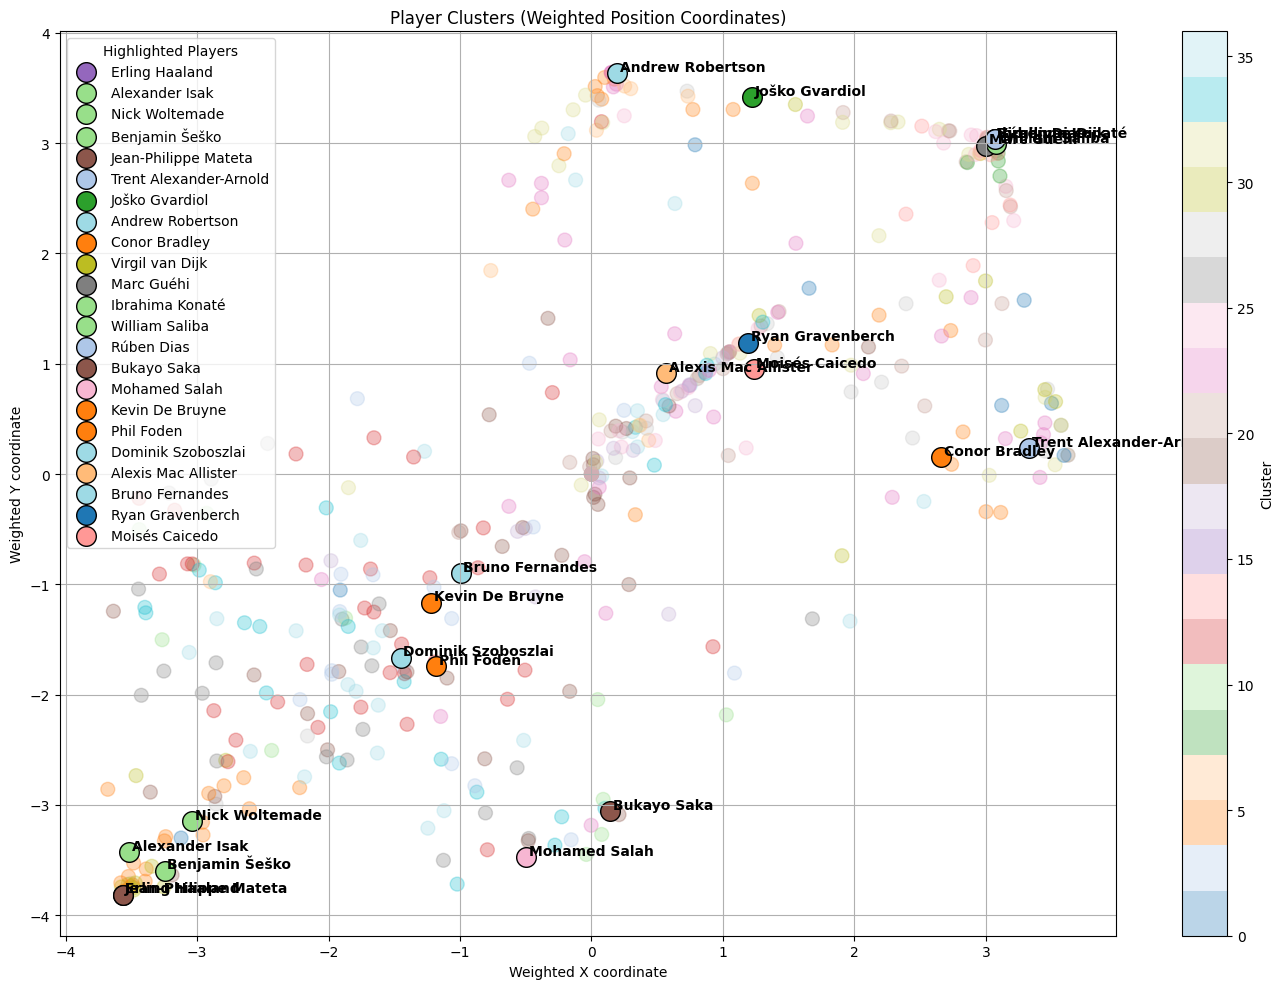

In [31]:
import matplotlib.pyplot as plt

# 假设 weighted_coords 已经是每个球员的加权坐标 (x, y)
# df_filtered['cluster'] 是聚类标签
x = weighted_coords[:, 0]
y = weighted_coords[:, 1]

# 你提供要高亮的球员名字列表
highlight_names = [
    "Erling Haaland", "Alexander Isak","Nick Woltemade","Benjamin Šeško","Jean-Philippe Mateta",
    "Trent Alexander-Arnold","Joško Gvardiol", "Andrew Robertson","Conor Bradley",
    "Virgil van Dijk","Marc Guéhi", "Ibrahima Konaté","William Saliba", "Rúben Dias",
    "Bukayo Saka", "Mohamed Salah",  
    "Kevin De Bruyne", "Phil Foden", "Dominik Szoboszlai", "Alexis Mac Allister", 
    "Bruno Fernandes","Ryan Gravenberch","Moisés Caicedo","Adam Wharton"]


plt.figure(figsize=(14, 10))

# 所有球员散点，半透明
scatter = plt.scatter(x, y, c=df_filtered['cluster'], cmap='tab20', s=100, alpha=0.3)

# 获取 colormap 对应 cluster 的颜色
cmap = plt.get_cmap('tab20')
clusters = df_filtered['cluster'].unique()
cluster_colors = {c: cmap(c % 20) for c in clusters}

# 用于高亮球员的 Legend handle 列表
highlight_handles = []

# 高亮球员
for name in highlight_names:
    mask = df_filtered['name'] == name
    if mask.sum() == 0:
        print(f"⚠️ {name} skipped")
        continue
    xi = x[mask][0]
    yi = y[mask][0]
    cluster_label = df_filtered.loc[mask, 'cluster'].values[0]
    
    # 高亮点
    sc = plt.scatter(xi, yi, s=200, color=cluster_colors[cluster_label], edgecolors='black')
    plt.text(xi + 0.02, yi + 0.02, name, fontsize=10, weight='bold')
    
    # 添加 Legend handle
    highlight_handles.append(sc)

# 添加高亮球员的单独 Legend
plt.legend(highlight_handles, [name for name in highlight_names if df_filtered['name'].isin([name]).any()],
           title="Highlighted Players", bbox_to_anchor=(0, 1), loc='upper left')

plt.xlabel('Weighted X coordinate')
plt.ylabel('Weighted Y coordinate')
plt.title('Player Clusters (Weighted Position Coordinates)')
plt.colorbar(scatter, label='Cluster')  # 保留 cluster 边栏
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
import json

# 按 cluster 分组，并选取最多 10 个球员
clustered_sample = {}
for cluster_id, group in df_filtered.groupby('cluster'):
    sample = group.sample(n=min(5, len(group)), random_state=42)
    # 只保留你需要的信息，比如 name 和 Pos_set
    clustered_sample[cluster_id] = sample[['name', 'Pos_set']].to_dict(orient='records')

# 写入 JSON 文件
with open('clustered_sample.json', 'w', encoding='utf-8') as f:
    json.dump(clustered_sample, f, ensure_ascii=False, indent=4)

print("JSON generated:clustered_sample.json")


JSON generated:clustered_sample.json


In [33]:
print("centroid shape:", centroids.shape)
print("centorids:\n", centroids)


centroid shape: (49, 29)
centorids:
 [[ 0.43194591 -1.34225767 -1.54657516 ... -0.40481464 -1.6116465
  -1.67948607]
 [-0.91477308 -0.64256043 -0.78080225 ...  0.24358861 -0.93618866
  -0.98738498]
 [ 1.33785739 -0.54162892 -0.51815663 ... -1.38022311  1.2697016
   1.19399534]
 ...
 [ 0.81338232  0.88832416  0.71842284 ... -0.90001786  1.30268891
   1.26246536]
 [-0.57557234  0.17366956  0.20654818 ... -0.44934043  0.27597643
   0.51315518]
 [-0.9589817   0.44153831  1.71001008 ... -0.09417718 -0.04472431
   0.68715894]]


# process rating data

In [34]:
import os
import json
import pandas as pd
from collections import defaultdict
from datetime import datetime
import re

# -------------------------------
# 配置路径
# -------------------------------
BASE_DIR = r"C:\Users\mhuiuyd\Desktop\RAW_TRACKS\National University of Singapore\Sandesh Sreepathy Upadhyaya - Football Dataset"
SEASON_FOLDERS = ["2526_FINAL"]
OUTPUT_CSV = "player_summary_all_seasons_latest.csv"
LATEST_NUM=6

TARGET_JSONS = [
    "defense.json",
    "keeper.json",
    "misc.json",
    "passing.json",
    "passing_types.json",
    "possession.json",
    "summary.json"
]


def safe_float_latest(x):
    """安全转换为 float"""
    try:
        return float(x)
    except (ValueError, TypeError):
        return None


def clean_info_fields_latest(info):
    """清洗 info.json 中的 height / weight 字段"""
    cleaned = dict(info)

    def is_invalid_height_or_weight(val: str) -> bool:
        if not isinstance(val, str):
            return False
        # 含有月份、字母、Age、括号的都判为异常
        if re.search(r"[A-Za-z]", val) or "(" in val or ")" in val:
            return True
        # 长度太短或太长也可能是异常
        if len(val) > 10:
            return True
        return False

    for key in ["height", "weight"]:
        val = cleaned.get(key)
        if val and is_invalid_height_or_weight(val):
            cleaned[key] = ""

    return cleaned


def process_player_folder_latest(player_folder):
    """处理单个球员文件夹，只取每个json中按Date最新的1场"""
    info_path = os.path.join(player_folder, "info.json")
    if not os.path.exists(info_path):
        return None

    # 读取 info.json
    with open(info_path, "r", encoding="utf-8") as f:
        try:
            info = json.load(f)
        except Exception:
            return None

    # 清洗异常 height / weight
    info = clean_info_fields_latest(info)

    player_name = info.get("name", None)
    if not player_name:
        return None

    numeric_max = {}
    match_num = 0
    pos_set = set()

    for file_name in TARGET_JSONS:
        file_path = os.path.join(player_folder, file_name)
        if not os.path.exists(file_path):
            continue

        # 读取文件
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                data = json.load(f)
            except Exception:
                continue

        # ✅ 按 Date 排序，仅取最新5场
        valid_items = []
        for item in data:
            date_str = item.get("Date")
            Min_str = item.get("Min")
            if not len(Min_str):
                continue
            try:
                item["_date"] = datetime.strptime(date_str, "%Y-%m-%d")
                valid_items.append(item)
            except Exception:
                continue

        if not valid_items:
            continue

        valid_items.sort(key=lambda x: x["_date"], reverse=True)
        recent_items = valid_items[:LATEST_NUM]

        candidate_match_num = 0
        file_sums = defaultdict(float)

        for item in recent_items:
            min_val = safe_float_latest(item.get("Min"))
            if min_val is None:
                continue
            candidate_match_num += 1

            for k, v in item.items():
                val = safe_float_latest(v)
                if val is not None:
                    file_sums[k] += val

            pos_val = item.get("Pos", "")
            if pos_val and pos_val != "On matchday squad, but did not play":
                for p in pos_val.replace(" ", "").split(","):
                    if p:
                        pos_set.add(p)

        # 不同文件间取最大值
        for k, v in file_sums.items():
            if k in numeric_max:
                numeric_max[k] = max(numeric_max[k], v)
            else:
                numeric_max[k] = v

        match_num = max(match_num, candidate_match_num)

    numeric_max["Pos_set"] = ", ".join(sorted(pos_set))
    numeric_max["Match_num"] = match_num

    return {**info, **numeric_max}


def aggregate_all_players_latest():
    """跨赛季汇总，仅取每名球员最新5场"""
    all_players = defaultdict(lambda: defaultdict(list))
    all_positions = defaultdict(set)
    base_info = {}

    for season in SEASON_FOLDERS:
        season_path = os.path.join(BASE_DIR, season)
        if not os.path.exists(season_path):
            print(f"⚠️ 跳过不存在的目录: {season_path}")
            continue

        for club in os.listdir(season_path):
            club_path = os.path.join(season_path, club)
            if not os.path.isdir(club_path):
                continue

            for player in os.listdir(club_path):
                player_folder = os.path.join(club_path, player)
                if not os.path.isdir(player_folder):
                    continue

                result = process_player_folder_latest(player_folder)
                if not result:
                    continue

                name = result.get("name")
                base_info[name] = {k: result[k] for k in ["name", "height", "weight", "Footed"] if k in result}

                # 聚合数值
                for k, v in result.items():
                    if isinstance(v, (int, float)):
                        all_players[name][k].append(v)

                # 聚合位置
                if "Pos_set" in result and result["Pos_set"]:
                    all_positions[name].update(result["Pos_set"].split(", "))

    # 汇总平均
    summary_rows = []
    for name in all_players:
        info = base_info.get(name, {})
        avg_dict = {k: sum(vs) for k, vs in all_players[name].items()}
        avg_dict["Pos_set"] = ", ".join(sorted(all_positions[name]))
        summary_rows.append({**info, **avg_dict})

    df = pd.DataFrame(summary_rows)
    df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
    print(f"✅ aggregate across season (latest{LATEST_NUM}): {OUTPUT_CSV}")
    print(f"📊 in total {len(df)} players")


if __name__ == "__main__":
    aggregate_all_players_latest()


✅ aggregate across season (latest6): player_summary_all_seasons_latest.csv
📊 in total 523 players


In [35]:
import os
import json
import pandas as pd
from collections import defaultdict

# -------------------------------
# 配置路径
# -------------------------------
CSV_FILE = "player_summary_all_seasons_latest.csv"

def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return None

def process_player_summary_latest(player_folder):
    """
    只读取 summary_all.json，统计每个位置出场分钟，计算熟练比重
    """
    summary_path = os.path.join(player_folder, "summary_all.json")
    if not os.path.exists(summary_path):
        return None

    with open(summary_path, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
        except Exception:
            return None

    pos_minutes = defaultdict(float)
    match_num = 0
    player_name = None

    for item in data:
        min_val = safe_float(item.get("Min"))
        if min_val is None:
            continue
        match_num += 1

        if not player_name:
            player_name = item.get("Player", None) or item.get("name", None)

        pos_val = item.get("Pos", "")
        if pos_val and pos_val != "On matchday squad, but did not play":
            positions = [p for p in pos_val.replace(" ", "").split(",") if p]
            for p in positions:
                pos_minutes[p] += min_val

    total_min = sum(pos_minutes.values())
    pos_weights = {p: pos_minutes[p] / total_min if total_min > 0 else 0 for p in pos_minutes}

    return player_name, pos_weights

# -------------------------------
# 读取原 CSV
# -------------------------------
df = pd.read_csv(CSV_FILE)

# -------------------------------
# 处理每个球员
# -------------------------------
pos_weights_list = []
for player_name in df['name']:
    found = False
    for season in SEASON_FOLDERS:
        season_path = os.path.join(BASE_DIR, season)
        for club in os.listdir(season_path):
            club_path = os.path.join(season_path, club)
            player_folder = os.path.join(club_path, player_name)
            if os.path.isdir(player_folder):
                result = process_player_summary_latest(player_folder)
                if result:
                    _, pos_weights = result
                    pos_weights_list.append(pos_weights)
                    found = True
                    break
        if found:
            break
    if not found:
        pos_weights_list.append({})  # 未找到的球员留空字典

# -------------------------------
# 添加 Pos_weights 列并保存
# -------------------------------
df['Pos_weights'] = pos_weights_list
df.to_csv(CSV_FILE, index=False, encoding="utf-8-sig")
print(f"✅ add {CSV_FILE}  Pos_weights col")


✅ add player_summary_all_seasons_latest.csv  Pos_weights col


In [36]:
import pandas as pd
import numpy as np

# 读取 CSV 文件
df = pd.read_csv("player_summary_all_seasons_latest.csv")

# 保留原样的字段
keep_cols = ["name", "height", "weight", "Footed", "Pos_set", "Match_num", "Min",'Pos_weights']

# 找到带%和非带%的数值列
percent_cols = [c for c in df.columns if "%" in c and c not in keep_cols]
numeric_cols = [c for c in df.columns if c not in keep_cols + percent_cols]

# 避免除0，先替换 Min 和 Match_num 为 1 的临时值
df["Min_temp"] = df["Min"].replace(0, 1)
df["Match_num_temp"] = df["Match_num"].replace(0, 1)

# 带%列除以 Match_num
for col in percent_cols:
    df[col] = df[col] / df["Match_num_temp"]

# 其他数值列除以 Min
for col in numeric_cols:
    df[col] = df[col] / df["Min_temp"]

# 删除临时列
df = df.drop(columns=["Min_temp", "Match_num_temp"])

df['Pos_set'] = df['Pos_weights'].apply(
    lambda w: split_WB_posset(
        parse_weights(w),
        list(parse_weights(w).keys()) if isinstance(parse_weights(w), dict) else list(range(len(parse_weights(w))))
    )[1]
)

df['Pos_weights'] = df['Pos_weights'].apply(
    lambda w: split_WB_posset(
        parse_weights(w),
        list(parse_weights(w).keys()) if isinstance(parse_weights(w), dict) else list(range(len(parse_weights(w))))
    )[0]
)

# 保存
df = df.dropna(subset=['height', 'weight', 'Footed']).copy()
df.to_csv("player_features_latest.csv", index=False, encoding="utf-8-sig")
negative_cols = [
    "Err",
    "Lost",
    "GA",
    "Mis"
    ]
for col in negative_cols:
    if col in df.columns:
        df[f"{col}_inv"] = -df[col]  # 取相反数
        # 如果希望删除原列，可以加上： df.drop(columns=[col], inplace=True)

# 保存修改后的 CSV
df.to_csv("player_features_latest_inverted.csv", index=False, encoding="utf-8-sig")
print("✅ gen modified file：player_features_latest_inverted.csv")

df = pd.read_csv("player_features_latest_inverted.csv")




✅ gen modified file：player_features_latest_inverted.csv


# RATING & Improvement Suggestion

In [37]:
import pandas as pd

In [38]:
rating_feature_cols = (
     defense_cols + offense_cols + 
    gk_cols + possession_cols + success_cols
)

In [39]:
import numpy as np
df = pd.read_csv("player_features_processed.csv")
# 假设 X 用于 KMeans 时是 df[all_feature_cols] 处理后的特征矩阵
# 如果你在聚类前对类别特征做了 one-hot 或标准化，需要同样处理
rate_col_indices = [df.columns.get_loc(col)-1 for col in rating_feature_cols if col in df.columns]
rate_col_indices = [df.columns.get_loc(col)-1 for col in rating_feature_cols if col in df.columns]
print(rate_col_indices)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [40]:
import pandas as pd 
import numpy as np 
from sklearn.metrics.pairwise import euclidean_distances # 假设 df 已经读取，centroids 已经计算 
from collections import Counter
import itertools
Nearest_n = 4
RATE_CONSTANT = 10
PROBLEM_NUM = 3

df = pd.read_csv("player_features_latest_inverted.csv") 
highlight_names_dict = {
    "Erling Haaland":9.2,
    "Joško Gvardiol":6.7, 
    "Rúben Dias":7.2,
    "Phil Foden":8.1, 

    "Alexander Isak":6.5,
    "Andrew Robertson":7.7,
    "Conor Bradley":6.5,
    "Virgil van Dijk":7.3,
    "Ibrahima Konaté":7.0,
    "Ryan Gravenberch":6.7,
    "Dominik Szoboszlai":7.6, 
    "Alexis Mac Allister":6.4, 
    "Florian Wirtz":6.8,
    "Mohamed Salah":6.4,  

    "Jean-Philippe Mateta":9.3,
    "Marc Guéhi":7.3,

    "Nick Woltemade":7.5,

    "Benjamin Šeško":7.0,
    "Bruno Fernandes":7.1,
    
    "William Saliba":7.4, 
    "Bukayo Saka":8.1, 
    "Gabriel Magalhães":7.1,

    "Konstantinos Mavropanos":6.9,
    "Calvin Bassey":6.7,
    "Max Kilman":7.3,
    "Santiago Bueno":6.7,
    
    "Moisés Caicedo":6.9
 } # 示例 
highlight_names = highlight_names_dict.keys()
# 1️⃣ 提取特征矩阵 
X, df, _, mean_latest, var_latest = df2X(df[all_feature_cols].copy(), "player_features_processed_latest.csv")

df = pd.read_csv("player_features_processed_latest.csv") 
# 获取 highlight_names 在 df 中的索引
missing = [n for n in highlight_names if n not in df["name"].values]
print("missing:", missing[:10])
indices = [df.index[df['name'] == name][0] for name in highlight_names]

# 按索引提取 X
X_selected = X[indices]

# 顺序对应
names_selected = highlight_names

# 计算欧式距离
dist_matrix = euclidean_distances(X_selected, centroids)

# 找最近的 cluster
sorted_idx = np.argsort(dist_matrix, axis=1)  # 从小到大排序
nearest_clusters_n = sorted_idx[:, :Nearest_n]        # 每行最小的 n 个簇索引
# 对应的距离
nearest_distances_n = np.take_along_axis(dist_matrix, nearest_clusters_n, axis=1)
# 输出
mae = 0 
for i, name in enumerate(names_selected):
    X_rate_selected = X_selected[:,rate_col_indices][i]
    mul_rate_centroids = centroids[:,rate_col_indices][nearest_clusters_n[i]]
    def rater(rate_centroids):
        rate_centroids_positive = np.where(rate_centroids > 0, rate_centroids, 0)
        X_rate_selected_pos = np.where(rate_centroids > 0, X_rate_selected, 0)
        shortage = np.where(X_rate_selected_pos < rate_centroids_positive, rating_feature_cols, "")
        r = np.sqrt(
            max(
                np.sum(
                    np.dot(X_rate_selected_pos,rate_centroids_positive)
                    )
                /np.sum(
                    np.dot(rate_centroids_positive,rate_centroids_positive)
                    ),
                0)
            )
        return r, shortage
    r=0
    shortage_list = []
    for dist, centroid in zip(nearest_distances_n[i],mul_rate_centroids):
        rate, shortage = rater(centroid)
        r+=rate/dist
        shortage_list.append(shortage)

    r = r/sum(1/nearest_distances_n[i])
    r= 5+5*r/RATE_CONSTANT
    mae += abs(r-highlight_names_dict[name])

    flat_list = itertools.chain.from_iterable(shortage_list)  # 展平
    filtered = [s for s in flat_list if s != ""]              # 去掉空字符串
    counter = Counter(filtered)
    
    top_n = [str(s) for s, _ in counter.most_common(PROBLEM_NUM)]
    print(f"{name} should improve on {top_n}")
mae/=len(names_selected)
print(f"rating MAE = {mae}")


✅ new file stored to: player_features_processed_latest.csv, shape:(361, 32)
missing: []
Erling Haaland should improve on ['Pass', 'Tkld%', 'Tkl%']
Joško Gvardiol should improve on ['Lost_inv', 'Rec', 'Blocks']
Rúben Dias should improve on ['Clr', 'GA_inv', 'Blocks']
Phil Foden should improve on ['Sh', 'PrgC', 'Tkld%']
Alexander Isak should improve on ['Tkl%', 'Pass', 'CPA']
Andrew Robertson should improve on ['GA_inv', 'Tkld%', 'Sh']
Conor Bradley should improve on ['Succ%', 'Dis', 'PrgR']
Virgil van Dijk should improve on ['Blocks', 'Mid 3rd', 'Lost_inv']
Ibrahima Konaté should improve on ['Tkl+Int', 'Att', 'GA_inv']
Ryan Gravenberch should improve on ['Lost_inv', 'Mis_inv', 'Blocks']
Dominik Szoboszlai should improve on ['PrgC', 'Dis', 'Tkld%']
Alexis Mac Allister should improve on ['SoTA', 'Sh', 'PrgR']
Florian Wirtz should improve on ['Sh', 'GA_inv', 'Dis']
Mohamed Salah should improve on ['Tkl%', 'Sh', 'PrgC']
Jean-Philippe Mateta should improve on ['Pass', 'GA_inv', 'Dis']
Marc G

In [41]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter

# 读取数据
df = pd.read_csv("player_features_processed_latest.csv")
# 所有球员名
all_names = df['name'].tolist()

# 计算所有球员的欧式距离
dist_matrix = euclidean_distances(X, centroids)

# 找每个球员最近的 n 个簇
sorted_idx = np.argsort(dist_matrix, axis=1)
nearest_clusters_n = sorted_idx[:, :Nearest_n]
nearest_distances_n = np.take_along_axis(dist_matrix, nearest_clusters_n, axis=1)

# 初始化结果保存
results = []
mae = 0
# 遍历每个球员
for i, name in enumerate(all_names):
    X_rate_selected = X[:, rate_col_indices][i]
    mul_rate_centroids = centroids[:, rate_col_indices][nearest_clusters_n[i]]

    def rater(rate_centroids):
        rate_centroids_positive = np.where(rate_centroids > 0, rate_centroids, 0)
        X_rate_selected_pos = np.where(rate_centroids > 0, X_rate_selected, 0)
        shortage = np.where(X_rate_selected_pos < rate_centroids_positive, rating_feature_cols, "")
        r = np.sqrt(
            max(
                np.sum(np.dot(X_rate_selected_pos, rate_centroids_positive))
                / np.sum(np.dot(rate_centroids_positive, rate_centroids_positive)),
                0
            )
        )
        return r, shortage

    r = 0
    shortage_list = []
    for dist, centroid in zip(nearest_distances_n[i], mul_rate_centroids):
        rate, shortage = rater(centroid)
        r += rate / dist
        shortage_list.append(shortage)

    r = r / sum(1 / nearest_distances_n[i])
    r = 5 + 5 * r / RATE_CONSTANT

    # 如果存在真实评分字典则计算误差
    if name in highlight_names_dict:
        mae += abs(r - highlight_names_dict[name])

    # 统计最常见的不足项
    flat_list = itertools.chain.from_iterable(shortage_list)
    filtered = [s for s in flat_list if s != ""]
    counter = Counter(filtered)
    top_n = [str(s) for s, _ in counter.most_common(PROBLEM_NUM)]


    # 保存结果
    player_row = df[df['name'] == player_name]
    pos_x = player_row['pos_x'].values[0]
    pos_y = player_row['pos_y'].values[0]

    results.append({
        "name": name,
        "pred_rating": r,
        "weakness": top_n,
        "pos_x": pos_x,
        "pos_y": pos_y
    })

# 转为 DataFrame 并保存
print(f"rating MAE = {mae/len(highlight_names)}")
results_df = pd.DataFrame(results)
results_df.to_csv("player_evaluation_results.csv", index=False)
print("✅ store: player_evaluation_results.csv")


rating MAE = 1.9181058900979542
✅ store: player_evaluation_results.csv


# DREAM 11 process data

In [42]:
mpos = {5: [0.4,0.25,0.15,0.12,0.08 ], 4: [0.5,0.25,0.15,0.1], 3:[0.5,0.3,0.2], 2:[0.7,0.3]}

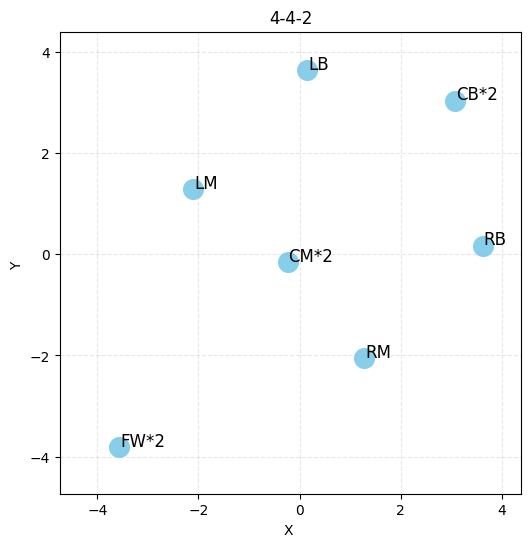

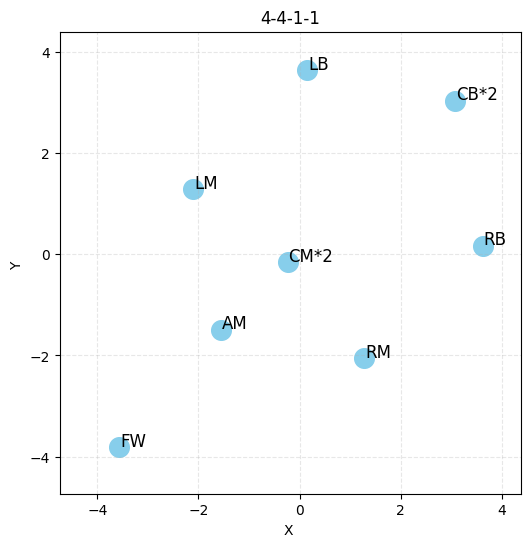

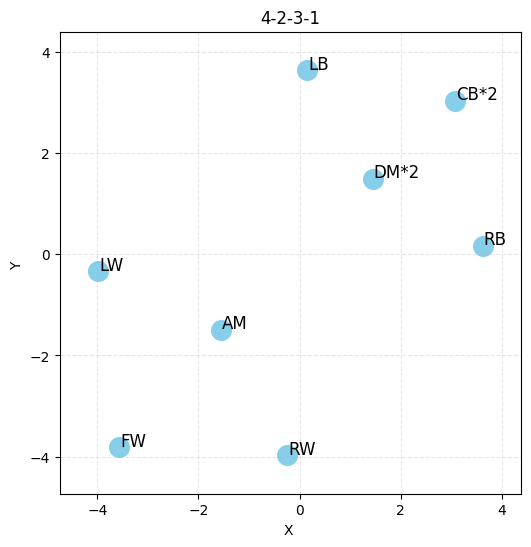

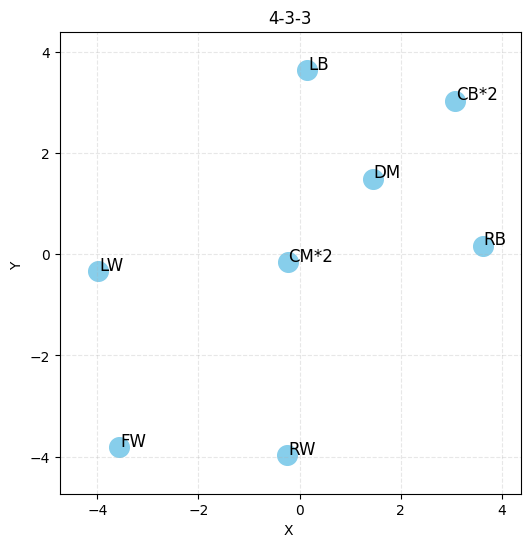

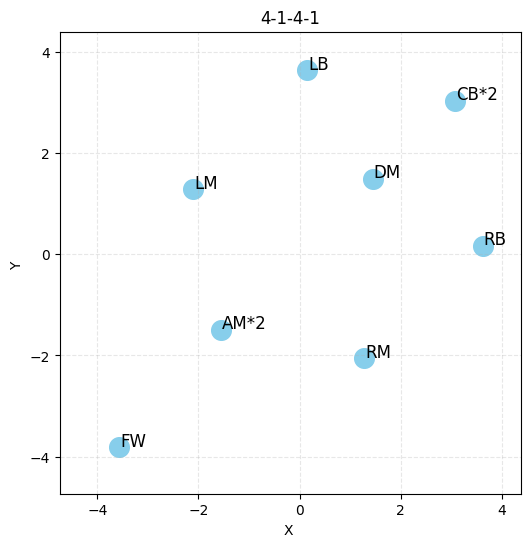

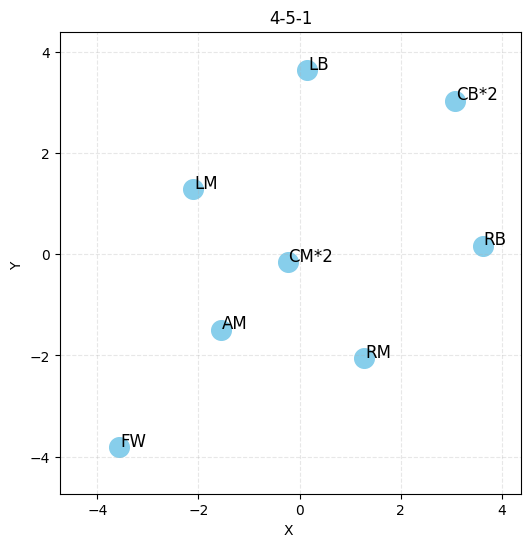

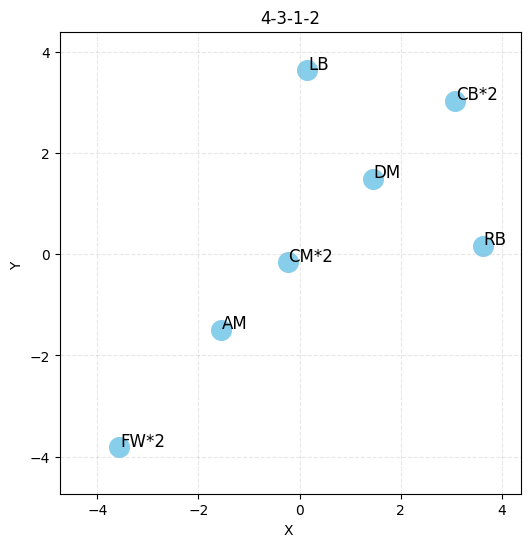

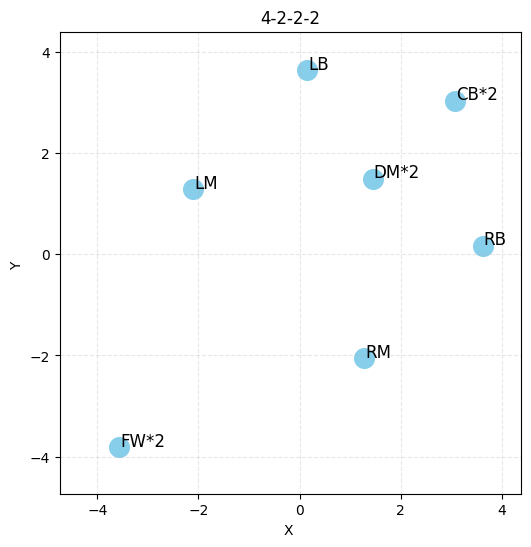

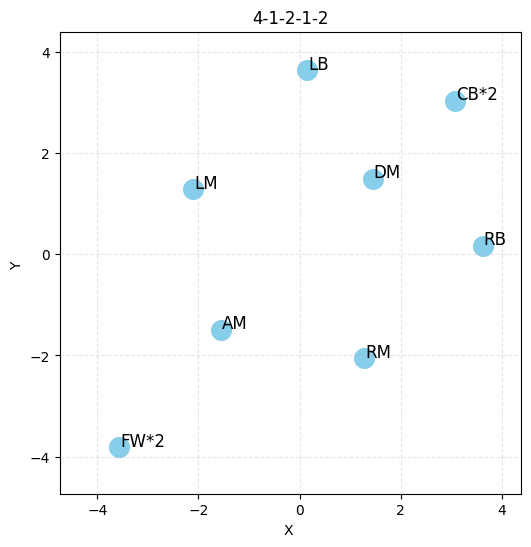

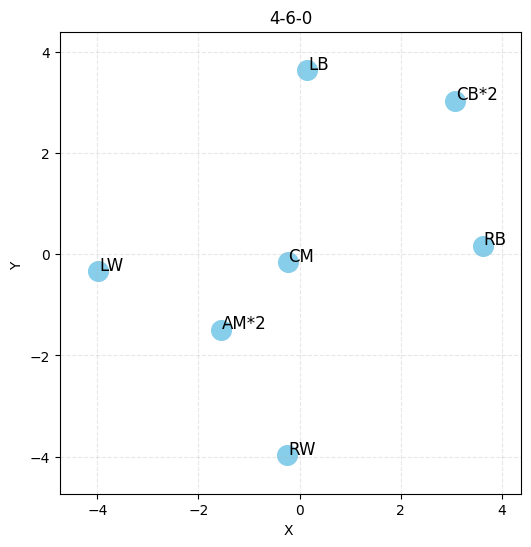

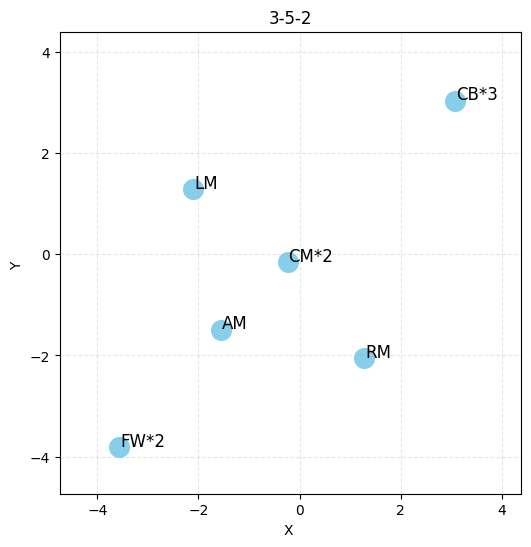

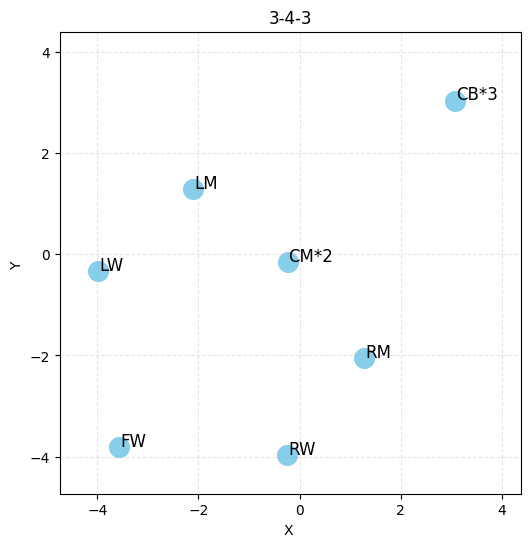

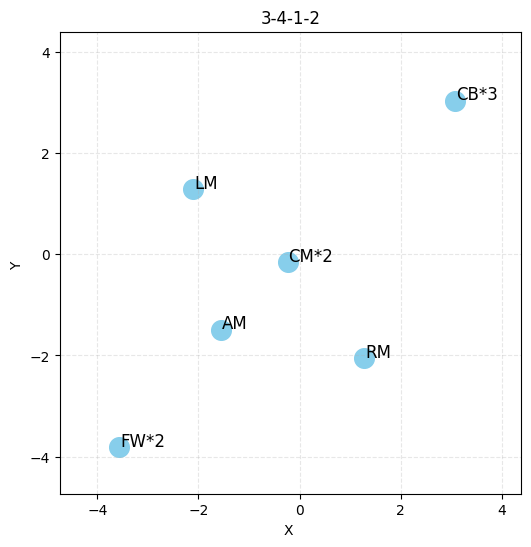

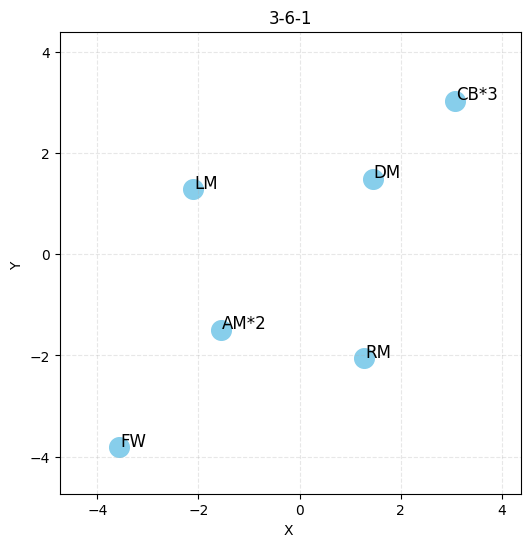

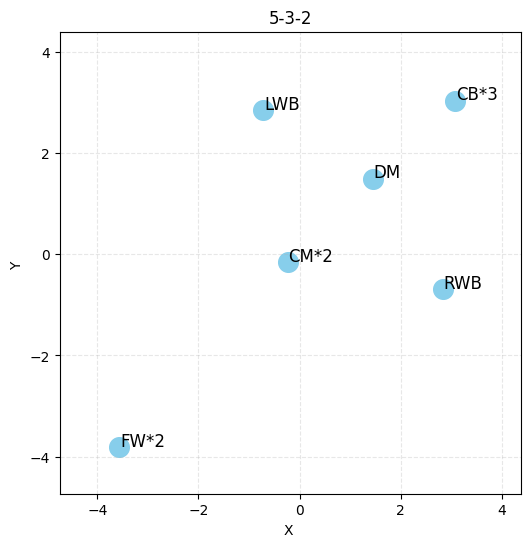

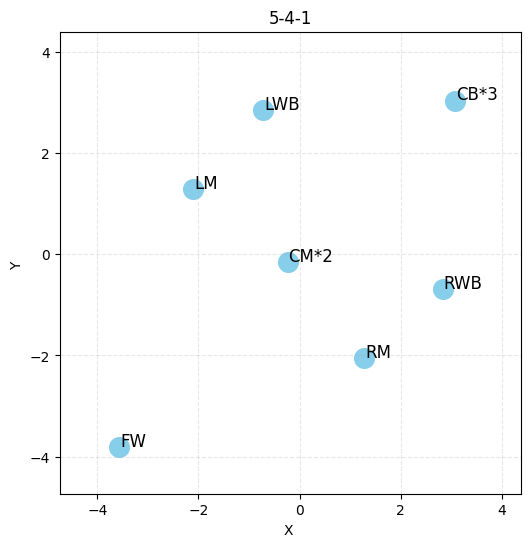

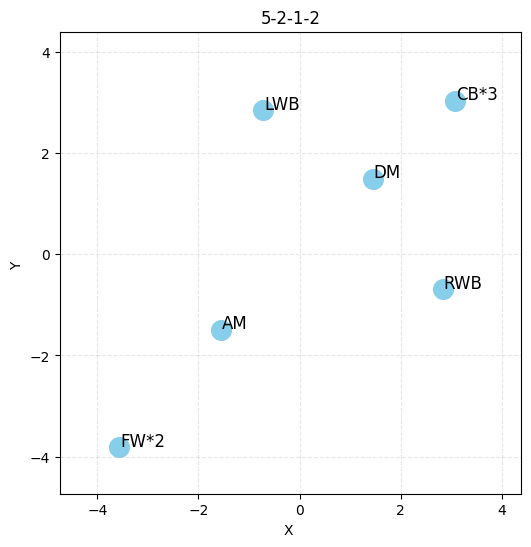

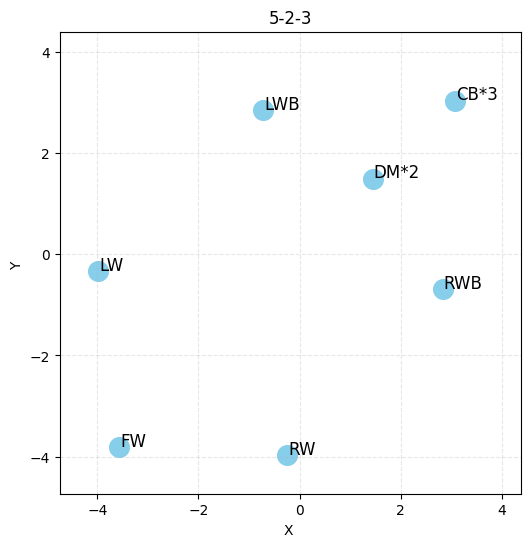

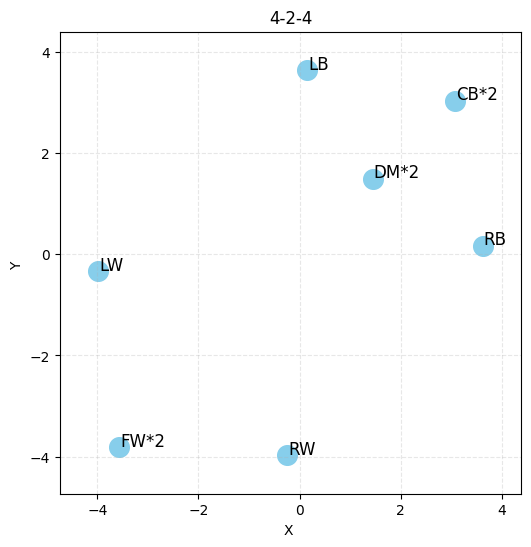

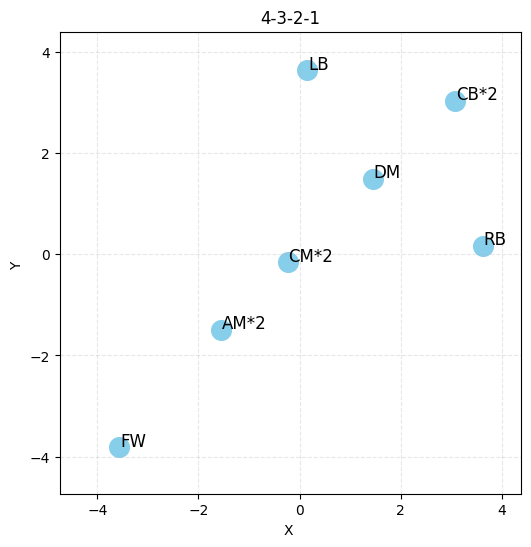

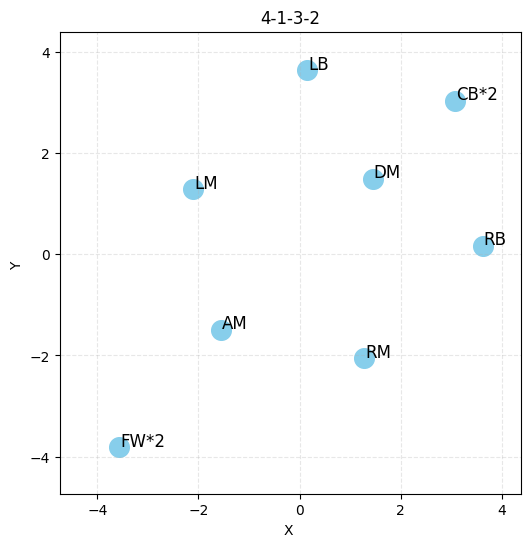

In [43]:
FORMATION_DICT = {
    "4-4-2": ["FW","FW","LM","CM","CM","RM","LB","CB","CB","RB"],
    "4-4-1-1": ["FW","AM","LM","CM","CM","RM","LB","CB","CB","RB"],
    "4-2-3-1": ["FW","LW","AM","RW","DM","DM","LB","CB","CB","RB"],
    "4-3-3": ["LW","FW","RW","CM","DM","CM","LB","CB","CB","RB"],
    "4-1-4-1": ["FW","LM","AM","AM","RM","DM","LB","CB","CB","RB"],
    "4-5-1": ["FW","LM","CM","AM","CM","RM","LB","CB","CB","RB"],
    "4-3-1-2": ["FW","FW","AM","CM","DM","CM","LB","CB","CB","RB"],
    "4-2-2-2": ["FW","FW","LM","RM","DM","DM","LB","CB","CB","RB"],
    "4-1-2-1-2": ["FW","FW","AM","LM","RM","DM","LB","CB","CB","RB"],
    "4-6-0": ["LW","CF","RW","AM","AM","CM","LB","CB","CB","RB"],
    "3-5-2": ["FW","FW","LM","CM","AM","CM","RM","CB","CB","CB"],
    "3-4-3": ["LW","FW","RW","LM","CM","CM","RM","CB","CB","CB"],
    "3-4-1-2": ["FW","FW","AM","LM","CM","CM","RM","CB","CB","CB"],
    "3-6-1": ["FW","LM","AM","AM","RM","DM","CB","CB","CB"],
    "5-3-2": ["FW","FW","CM","DM","CM","LWB","CB","CB","CB","RWB"],
    "5-4-1": ["FW","LM","CM","CM","RM","LWB","CB","CB","CB","RWB"],
    "5-2-1-2": ["FW","FW","AM","DM","","LWB","CB","CB","CB","RWB"],
    "5-2-3": ["LW","FW","RW","DM","DM","LWB","CB","CB","CB","RWB"],
    "4-2-4": ["LW","FW","FW","RW","DM","DM","LB","CB","CB","RB"],
    "4-3-2-1": ["FW","AM","AM","CM","DM","CM","LB","CB","CB","RB"],
    "4-1-3-2": ["FW","FW","LM","AM","RM","DM","LB","CB","CB","RB"]
}

for name, formation in FORMATION_DICT.items():
    coords = positions_to_coords()
    # 提取所有 x, y
    xs = [x for x, y in coords.values()]
    ys = [y for x, y in coords.values()]

    # 创建图
    plt.figure(figsize=(8,6))
    plt.title(name)
    plt.xlabel("X ")
    plt.ylabel("Y ")

    # 画每个位置
    for pos, (x, y) in coords.items():
        if pos in formation:
            if formation.count(pos)>1:
                pos = pos +"*"+str(formation.count(pos))
            plt.scatter(x, y, s=200, c='skyblue')
            plt.text(x+0.02, y+0.02, pos, fontsize=12)

    # 自动设置坐标范围并加边距
    x_margin = (max(xs)-min(xs))*0.1
    y_margin = (max(ys)-min(ys))*0.1
    plt.xlim(min(xs)-x_margin, max(xs)+x_margin)
    plt.ylim(min(ys)-y_margin, max(ys)+y_margin)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.show()

# rating based DREAM 11

In [44]:
Neart_pos_num = 3

In [45]:
import pandas as pd

# 1️⃣ 读取评分结果
eval_df = pd.read_csv("player_evaluation_results.csv")

# 取需要的列
eval_df = eval_df[['name', 'pred_rating']]

# 2️⃣ 读取球员特征数据
features_df = pd.read_csv("player_features_latest_inverted.csv")

# 3️⃣ 根据 name 合并两份数据，取 Pos_weights
# 确保 features_df 有 'name' 和 'Pos_weights' 列
merged_df = pd.merge(eval_df, 
                     features_df[['name', 'Pos_weights']], 
                     on='name', 
                     how='left')



In [46]:
import ast
all_pos = set()
for d in merged_df['Pos_weights']:
    w_dict = ast.literal_eval(d) if isinstance(d, str) else d
    all_pos.update(w_dict.keys())
all_pos = list(all_pos)
print(all_pos)
# 存储每个 pos 的 top 10
top_players_per_pos = {}

for pos in all_pos:
    mask = merged_df['Pos_weights'].apply(
        lambda x: ast.literal_eval(x).get(pos, 0) > 0.3 if isinstance(x, str) else x.get(pos, 0) > 0.3
    )
    filtered = merged_df[mask]
    top10 = filtered.sort_values('pred_rating', ascending=False).head(10)
    top_players_per_pos[pos] = top10[['name', 'pred_rating']].reset_index(drop=True)

# 查看某个位置的 top10
print(top_players_per_pos['CB'])

['AM', 'RB', 'DM', 'LWB', 'LM', 'FW', 'CM', 'LB', 'RWB', 'CB', 'LW', 'RM', 'RW']
                name  pred_rating
0       Jorge Cuenca     5.610029
1        Joe Worrall     5.594589
2          Joe Gomez     5.588876
3     Santiago Bueno     5.489326
4  Benoît Badiashile     5.487610
5   Jamaal Lascelles     5.476979
6           Dan Burn     5.460063
7     Chris Richards     5.445176
8     William Saliba     5.444836
9      Marcos Senesi     5.437141


In [47]:
import pandas as pd
import ast

# 确保 Pos_weights 是字典
merged_df['Pos_weights'] = merged_df['Pos_weights'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

top_teams_unique = {}

for formation_name, positions in FORMATION_DICT.items():
    team = []
    used_players = set()  # 已上场球员
    team_score = 0
    
    for pos in positions:
        # 筛选权重大于0.3且未上场的球员
        candidates = merged_df[
            (merged_df['Pos_weights'].apply(lambda x: x.get(pos,0) > 0.3)) &
            (~merged_df['name'].isin(used_players))
        ]
        
        if len(candidates) == 0:
            # 如果没有合适的候选，可以填 None 或选权重最高未上场球员
            team.append({'pos': pos, 'name': None, 'pred_rating': 0})
            continue
        
        # 选择 pred_rating 最高的球员
        best_player = candidates.sort_values('pred_rating', ascending=False).iloc[0]
        team.append({'pos': pos, 'name': best_player['name'], 'pred_rating': best_player['pred_rating']})
        used_players.add(best_player['name'])
        team_score += best_player['pred_rating']
    
    top_teams_unique[formation_name] = {'team': team, 'total_rating': team_score}

# 查看 4-4-2 阵型评分最高队伍（无重复球员）
for player in top_teams_unique['4-4-2']['team']:
    print(player)
print("Total rating:", top_teams_unique['4-4-2']['total_rating'])


{'pos': 'FW', 'name': 'Odsonne Édouard', 'pred_rating': np.float64(5.722993585008704)}
{'pos': 'FW', 'name': 'Sasa Kalajdzic', 'pred_rating': np.float64(5.598138859137577)}
{'pos': 'LM', 'name': 'Jeremy Doku', 'pred_rating': np.float64(5.539581611178011)}
{'pos': 'CM', 'name': 'Christian Nørgaard', 'pred_rating': np.float64(5.826576767552558)}
{'pos': 'CM', 'name': 'Rayan Cherki', 'pred_rating': np.float64(5.492304994267768)}
{'pos': 'RM', 'name': 'Sávio', 'pred_rating': np.float64(5.422519018230462)}
{'pos': 'LB', 'name': 'James Justin', 'pred_rating': np.float64(5.527628061660565)}
{'pos': 'CB', 'name': 'Jorge Cuenca', 'pred_rating': np.float64(5.610028639627783)}
{'pos': 'CB', 'name': 'Joe Worrall', 'pred_rating': np.float64(5.594588755700964)}
{'pos': 'RB', 'name': 'Noussair Mazraoui', 'pred_rating': np.float64(5.483276506891846)}
Total rating: 55.81763679925624


In [48]:
# 假设 top_teams_unique 已经生成
# top_teams_unique: {formation_name: {'team': [...], 'total_rating': ...}, ...}

best_formation = None
best_score = -1

for formation_name, info in top_teams_unique.items():
    if info['total_rating'] > best_score:
        best_score = info['total_rating']
        best_formation = formation_name

print(f"formation: {best_formation}, total rating: {best_score}")
print("player list：")
for player in top_teams_unique[best_formation]['team']:
    print(player)
dream_team = {
    "formation": best_formation,
    "team": top_teams_unique[best_formation]["team"]
}

# 保存为 dream11.json（UTF-8，带缩进）
with open("dream11.json", "w", encoding="utf-8") as f:
    json.dump(dream_team, f, ensure_ascii=False, indent=4)

print("✅ Dream 11 saved dream11.json")


formation: 4-3-1-2, total rating: 56.72500923815482
player list：
{'pos': 'FW', 'name': 'Odsonne Édouard', 'pred_rating': np.float64(5.722993585008704)}
{'pos': 'FW', 'name': 'Sasa Kalajdzic', 'pred_rating': np.float64(5.598138859137577)}
{'pos': 'AM', 'name': 'Jadon Sancho', 'pred_rating': np.float64(5.794616597315553)}
{'pos': 'CM', 'name': 'Christian Nørgaard', 'pred_rating': np.float64(5.826576767552558)}
{'pos': 'DM', 'name': 'Mateo Kovačić', 'pred_rating': np.float64(6.074856470991502)}
{'pos': 'CM', 'name': 'Rayan Cherki', 'pred_rating': np.float64(5.492304994267768)}
{'pos': 'LB', 'name': 'James Justin', 'pred_rating': np.float64(5.527628061660565)}
{'pos': 'CB', 'name': 'Jorge Cuenca', 'pred_rating': np.float64(5.610028639627783)}
{'pos': 'CB', 'name': 'Joe Worrall', 'pred_rating': np.float64(5.594588755700964)}
{'pos': 'RB', 'name': 'Noussair Mazraoui', 'pred_rating': np.float64(5.483276506891846)}
✅ Dream 11 saved dream11.json
